# Data Extraction

In [4]:
from bs4 import BeautifulSoup
import requests

r = requests.get("https://www.transtats.bts.gov/Data_Elements.aspx?Qn6n=E", verify = False)
soup = BeautifulSoup(r.content, 'html.parser')
table_found = soup.find_all(['table'])[10]

/Users/abizagrace/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py:981: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.transtats.bts.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings


In [2]:
import pandas as pd

airtraf = pd.read_html(str(table_found))
airtraf = airtraf[0]
airtraf.drop(airtraf[airtraf['Month'] == "TOTAL"].index, inplace = True)
airtraf.drop(airtraf[airtraf['Year'] < 2010].index, inplace = True)
airtraf = airtraf.reset_index()
del airtraf['index']

airtraf.head(12)


,Year,Month,DOMESTIC,INTERNATIONAL,TOTAL
0,2010,1,45501620,12393439,57895059
1,2010,2,42440614,10694165,53134779
2,2010,3,54424077,13279320,67703397
3,2010,4,52498074,12398700,64896774
4,2010,5,53842422,13380664,67223086
5,2010,6,56689853,14406776,71096629
6,2010,7,59142493,16026852,75169345
7,2010,8,57370748,15317926,72688674
8,2010,9,50304708,12599149,62903857
9,2010,10,54826050,12874707,67700757


In [8]:
airtraf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           134 non-null    int64 
 1   Month          134 non-null    object
 2   DOMESTIC       134 non-null    int64 
 3   INTERNATIONAL  134 non-null    int64 
 4   TOTAL          134 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 5.4+ KB


In [6]:
import numpy as np
import sqlalchemy as sqla
import requests_cache
import plotnine as p9
requests_cache.install_cache('covidcast_cache')
import os, json
import glob
from scipy.stats import spearmanr
import matplotlib
import matplotlib.pyplot as plt

r_data_csv = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
r_data_csv = r_data_csv[r_data_csv['Country_code'].isin(['US'])]
r_data_csv = r_data_csv.drop(['Country','WHO_region'],axis=1)
r_data_csv.set_index('Date_reported', inplace=True)
r_data_csv.index = pd.to_datetime(r_data_csv.index)
r_data_csv = r_data_csv.resample('1M').sum()
r_data_csv


,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
Date_reported,,,,
2020-01-31,47,354,0,0
2020-02-29,79,2328,1,1
2020-03-31,145687,801004,2643,13399
2020-04-30,862587,17730878,56229,856114
2020-05-31,731931,43648177,45098,2643117
2020-06-30,813512,63128418,23765,3484243
2020-07-31,1864090,107634613,27135,4349586
2020-08-31,1508065,162644591,30939,5318293
2020-09-30,1184379,195820984,21543,5916040


In [28]:
r_data_csv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18 entries, 2020-01-31 to 2021-06-30
Freq: M
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   New_cases          18 non-null     int64
 1   Cumulative_cases   18 non-null     int64
 2   New_deaths         18 non-null     int64
 3   Cumulative_deaths  18 non-null     int64
dtypes: int64(4)
memory usage: 720.0 bytes


# Data Visualization

In [10]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

<AxesSubplot:title={'center':'Total Flights Against Year'}, xlabel='Year', ylabel='DOMESTIC'>

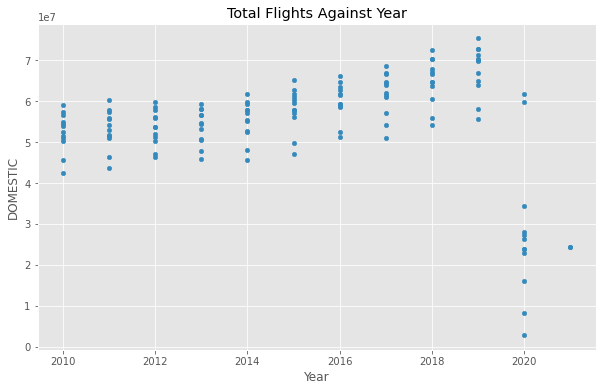

In [12]:
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10,6)

airtraf.plot('Year','DOMESTIC',kind='scatter',
                 title='Domestic Flights Against Year')

<AxesSubplot:title={'center':'International Flights Against Year'}, xlabel='Year', ylabel='INTERNATIONAL'>

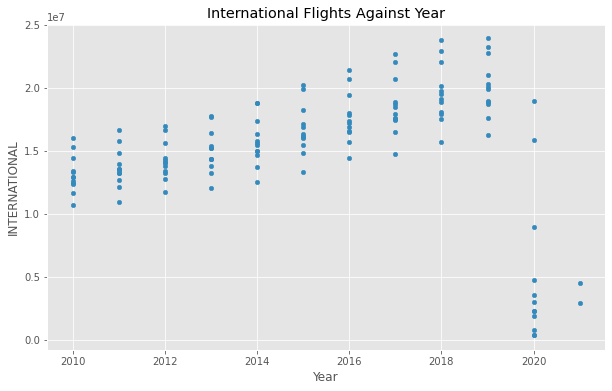

In [13]:
airtraf.plot('Year','INTERNATIONAL',kind='scatter',
                 title='International Flights Against Year')

<AxesSubplot:title={'center':'Total Flights Against Year'}, xlabel='Year', ylabel='TOTAL'>

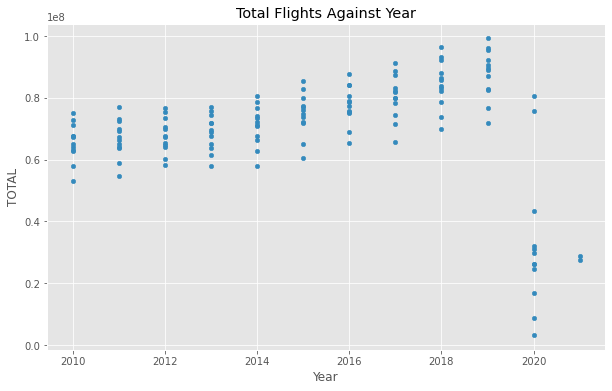

In [15]:
airtraf.plot('Year','TOTAL',kind='scatter',
                 title='Total Flights Against Year')

## Combine Month and Year 

In [33]:
airtraf['Date'] = pd.to_datetime(airtraf[['Year', 'Month']].assign(DAY=1))
airtraf.head()
#airtraf.info()

,Year,Month,DOMESTIC,INTERNATIONAL,TOTAL,Date
0,2010,1,45501620,12393439,57895059,2010-01-01
1,2010,2,42440614,10694165,53134779,2010-02-01
2,2010,3,54424077,13279320,67703397,2010-03-01
3,2010,4,52498074,12398700,64896774,2010-04-01
4,2010,5,53842422,13380664,67223086,2010-05-01


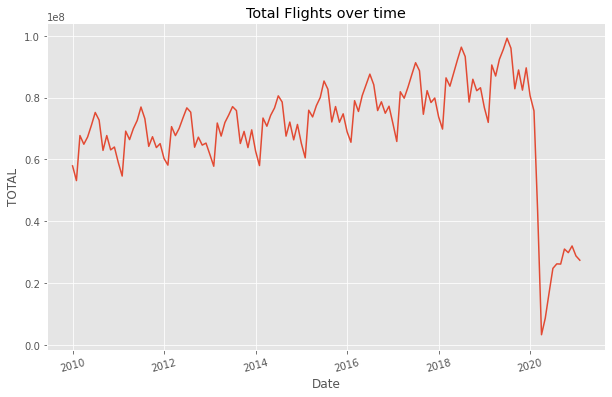

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.lineplot(x="Date", y="TOTAL", data=airtraf)
plt.xticks(rotation=15)
plt.title('Total Flights over time')
plt.show()

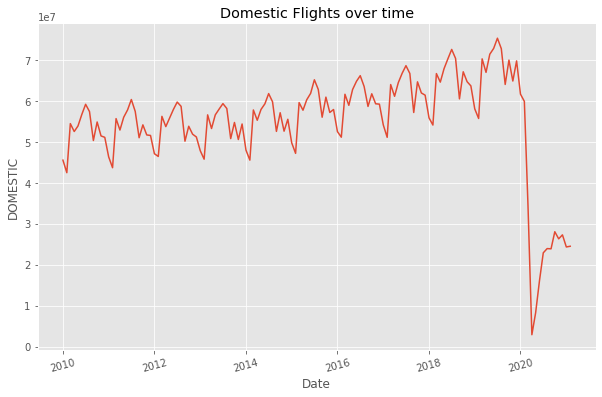

In [26]:
sns.lineplot(x="Date", y="DOMESTIC", data=airtraf)
plt.xticks(rotation=15)
plt.title('Domestic Flights over time')
plt.show()

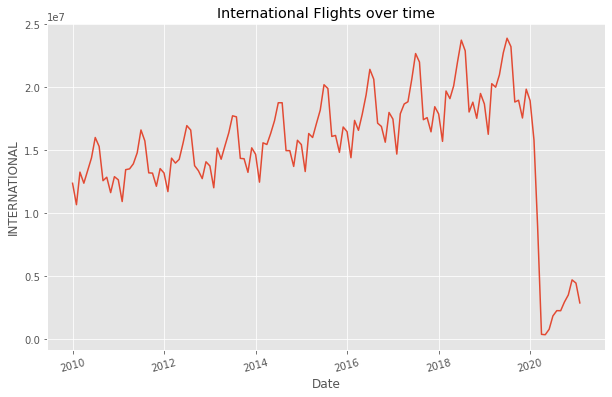

In [27]:
sns.lineplot(x="Date", y="INTERNATIONAL", data=airtraf)
plt.xticks(rotation=15)
plt.title('International Flights over time')
plt.show()

## Covid Death Graphs 

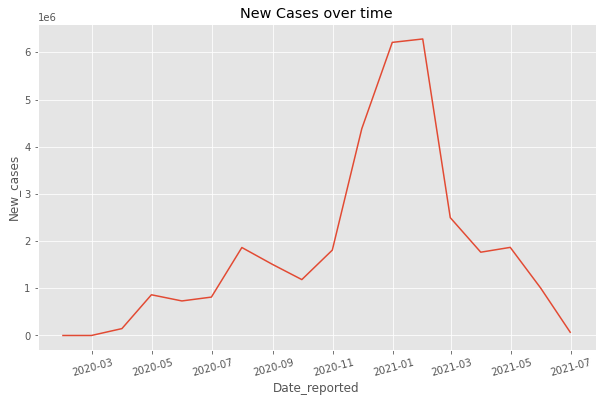

In [29]:
sns.lineplot(x="Date_reported", y="New_cases", data=r_data_csv)
plt.xticks(rotation=15)
plt.title('New Cases over time')
plt.show()

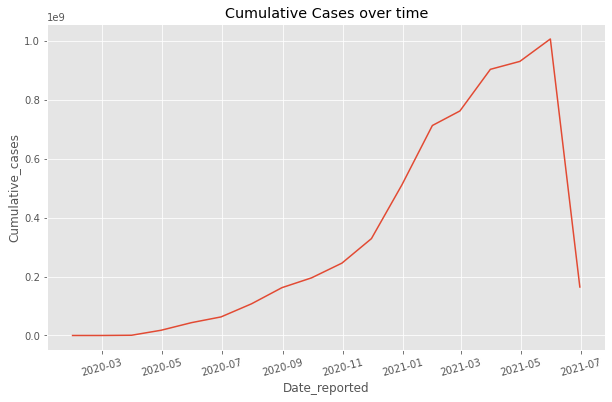

In [30]:
sns.lineplot(x="Date_reported", y="Cumulative_cases", data=r_data_csv)
plt.xticks(rotation=15)
plt.title('Cumulative Cases over time')
plt.show()

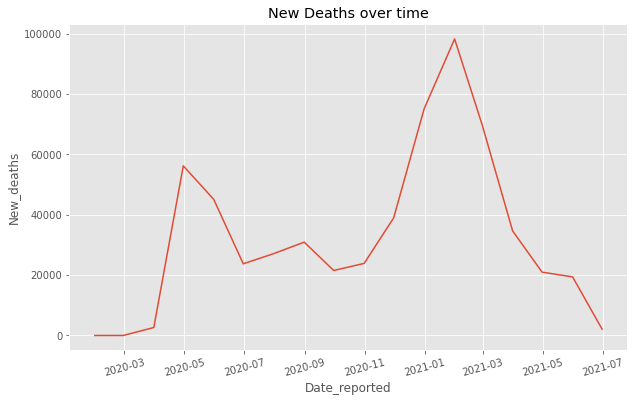

In [31]:
sns.lineplot(x="Date_reported", y="New_deaths", data=r_data_csv)
plt.xticks(rotation=15)
plt.title('New Deaths over time')
plt.show()

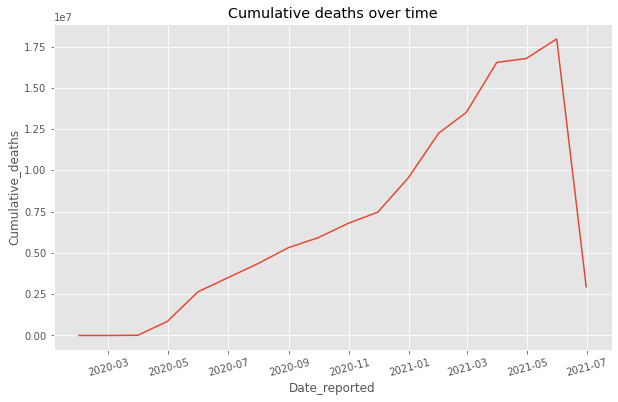

In [32]:
sns.lineplot(x="Date_reported", y="Cumulative_deaths", data=r_data_csv)
plt.xticks(rotation=15)
plt.title('Cumulative deaths over time')
plt.show()

## Comined Time Seires

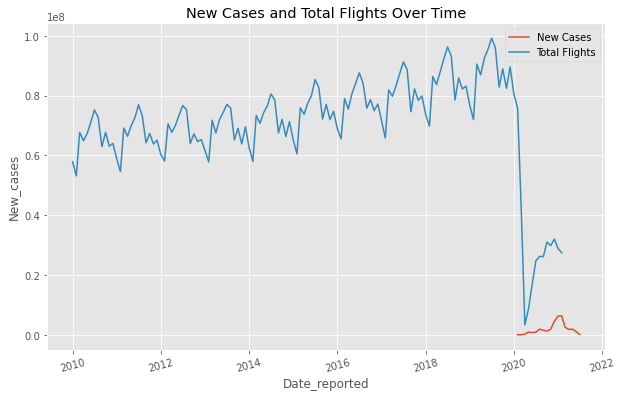

In [52]:
sns.lineplot(x="Date_reported", y="New_cases", data=r_data_csv, label = "New Cases")
sns.lineplot(x="Date", y="TOTAL", data=airtraf, label= "Total Flights")
plt.xticks(rotation=15)
plt.title('New Cases and Total Flights Over Time')
plt.show()

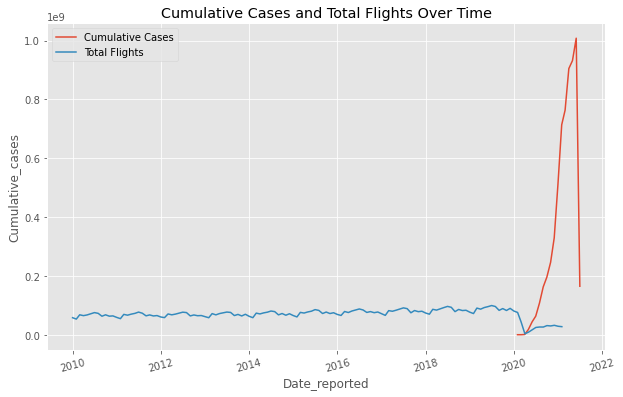

In [51]:
sns.lineplot(x="Date_reported", y="Cumulative_cases", data=r_data_csv, label = "Cumulative Cases")
sns.lineplot(x="Date", y="TOTAL", data=airtraf, label= "Total Flights")
plt.xticks(rotation=15)
plt.title('Cumulative Cases and Total Flights Over Time')
plt.show()

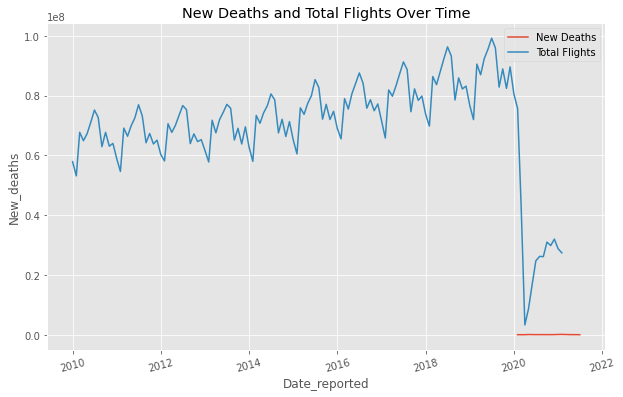

In [50]:
sns.lineplot(x="Date_reported", y="New_deaths", data=r_data_csv, label = "New Deaths")
sns.lineplot(x="Date", y="TOTAL", data=airtraf, label= "Total Flights")
plt.xticks(rotation=15)
plt.title('New Deaths and Total Flights Over Time')
plt.show()

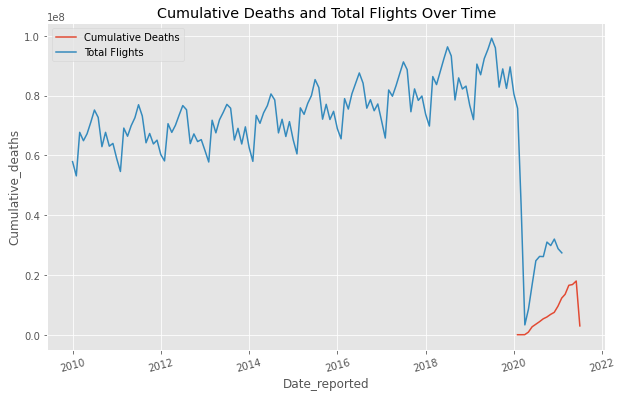

In [49]:
sns.lineplot(x="Date_reported", y="Cumulative_deaths", data=r_data_csv, label = "Cumulative Deaths")
sns.lineplot(x="Date", y="TOTAL", data=airtraf, label= "Total Flights")
plt.xticks(rotation=15)
plt.title('Cumulative Deaths and Total Flights Over Time')
plt.show()